# Compute MoSeq distances from behavior to behavior in the model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import joblib
from tqdm.auto import tqdm

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [7]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]

In [8]:
def simulate_ar_trajectory(ar_mat, init_points=None, sim_points=100):

    npcs = ar_mat.shape[0]

    if ar_mat.shape[1] % npcs == 1:
        affine_term = ar_mat[:, -1]
        ar_mat = np.delete(ar_mat, ar_mat.shape[1] - 1, axis=1)
    else:
        affine_term = np.zeros((ar_mat.shape[0],), dtype="float32")

    nlags = ar_mat.shape[1] // npcs

    if init_points is None:
        init_points = np.zeros((nlags, npcs), dtype="float32")

    sim_mat = np.zeros((sim_points + nlags, npcs), dtype="float32")
    sim_mat[:nlags] = init_points[:nlags]

    use_mat = np.zeros((nlags, npcs, npcs))

    for i in range(len(use_mat)):
        use_mat[i] = ar_mat[:, i * npcs : (i + 1) * npcs]

    for i in range(sim_points):
        sim_idx = i + nlags
        result = 0
        for j in range(1, nlags + 1):
            result += sim_mat[sim_idx - j].dot(use_mat[nlags - j])
        result += affine_term

        sim_mat[sim_idx, :] = result

    return sim_mat[nlags:]

In [10]:
arhmm_path = os.path.join(raw_dirs["realtime_package"], "arhmm.p")
arhmm = joblib.load(arhmm_path)["model"]

In [11]:
sims = []
for i in tqdm(range(100)):
    ar_sim = simulate_ar_trajectory(arhmm.obs_distns[i].A, sim_points=10)
    sims.append(ar_sim)

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
all_sims = np.array(sims)

In [13]:
from scipy.spatial.distance import squareform, pdist

In [15]:
use_idx = np.flatnonzero(
    ~(np.isnan(all_sims).any(axis=(1, 2)) | (all_sims > 1e3).any(axis=(1, 2)))
)

In [16]:
valid_sims = all_sims[use_idx]

In [18]:
dist_mat = squareform(
    pdist(valid_sims.reshape(-1, np.prod(valid_sims.shape[1:])), "correlation")
)

In [19]:
dist_df = pd.DataFrame(dist_mat, index=use_idx, columns=use_idx)

/home/markowitzmeister_gmail_com/miniconda3/envs/moseq-distance/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


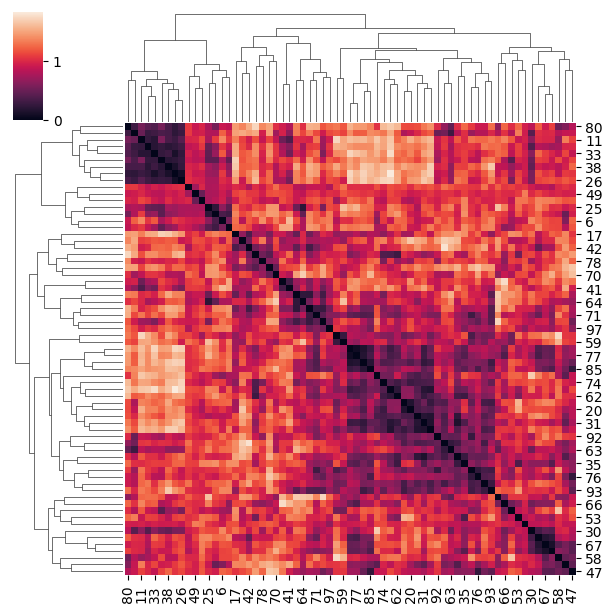

In [20]:
g = sns.clustermap(dist_df)
g.fig.set_size_inches(6, 6)

In [21]:
save_file = os.path.join(
    proc_dirs["closed_loop_behavior"], "behavioral-distance.parquet"
)

In [22]:
# need to convert to string for storage
dist_df.columns = dist_df.columns.astype(str)

In [23]:
dist_df.to_parquet(save_file)